In [1]:
# import statements
import numpy as np
import xarray as xr
import glob
import random
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import sys
import matplotlib.pyplot as plt
import TestingTrainingSplit_CV
from matplotlib.colors import LinearSegmentedColormap


# Get names of models in which we are testing on
path_to_data = '/home/disk/pna2/aodhan/SurfaceTrendLearning/PoChedleyEtAl2022/TASsplicedmaps/*_TrendMaps.nc'
ModelNames = [i[70:-16] for i in glob.glob(path_to_data)]

# Get observational data
#observational_trends = glob.glob('/home/disk/p/aodhan/SurfaceTrendLearing/TropicalTASApplication/TASObsTrends/*.npy')
#observational_trend_maps = [np.load(observational_trends[i]) for i in range(0,len(observational_trends))]
#latitudes = np.linspace(-88.75,88.75,72)
#weights = np.cos(np.deg2rad(latitudes)) # these will be used to weight predictors
#observational_trend_maps_weighted = np.multiply(observational_trend_maps, weights[np.newaxis,:,np.newaxis])
#observational_trend_maps_reshaped = np.reshape(observational_trend_maps_weighted, (3, 72*144))

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# Do CV train-test-split 
TrainingPredictorData, TrainingTargetData, TestingPredictorData, TestingTargetData, TestingTotalTrend = TestingTrainingSplit_CV.training_testing_split(path_to_data)


In [2]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit
from scipy import stats
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor

# iterate over all CV folds (there should be eqaul number of CV folds as models)
NameValidatationPredictions = []
gistemp_predictions = []
era5_predictions = []
hadcrut_predictions = []
for model_idx in range(len(ModelNames)):
    
    # Reshape target and predictor data for model
    TrainingTargetDataShape = np.shape(TrainingTargetData[model_idx])
    TestinTargetDataShape = np.shape(TestingTargetData[model_idx])
    TrainingTargetDataReshaped = np.reshape(TrainingTargetData[model_idx], (TrainingTargetDataShape[0], TrainingTargetDataShape[1]*TrainingTargetDataShape[2]))
    TestingTargetDataReshaped = np.reshape(TestingTargetData[model_idx], (TestinTargetDataShape[0], TestinTargetDataShape[1]*TestinTargetDataShape[2]))

    # Model Design
    MLmodel = PLSRegression(n_components=2)
    
    # Train model
    TrainingTargetDataReshaped = np.transpose([TrainingTargetDataReshaped[:,0], TrainingTargetDataReshaped[:,3]])

    #TrainingTargetDataReshaped = TrainingTargetDataReshaped[:,0]
    pls_model = MLmodel.fit(TrainingPredictorData[model_idx], TrainingTargetDataReshaped)

    # Predict using trained model
    Y_pred = MLmodel.predict(TestingPredictorData[model_idx])
    
    # Apply trained model to observations
    #Y_pred_Gistemp = MLmodel.predict(observational_trend_maps_reshaped[0].reshape(1, -1))
    #Y_pred_ERA5 = MLmodel.predict(observational_trend_maps_reshaped[1].reshape(1, -1))
    #Y_pred_HadCrut = MLmodel.predict(observational_trend_maps_reshaped[2].reshape(1, -1))
    Y_test = np.transpose([TestingTargetDataReshaped[:,0], TestingTargetDataReshaped[:,3]])
    # Save output for plotting
    NameValidatationPredictions.append([ModelNames[model_idx], TestingTargetDataReshaped, Y_pred])
    #gistemp_predictions.append(Y_pred_Gistemp)
    #era5_predictions.append(Y_pred_ERA5)
    #hadcrut_predictions.append(Y_pred_HadCrut)
    #validations.append([TestingTargetDataReshaped[:,0]])
    #predictions.append(Y_pred)
    print(ModelNames[model_idx])
    print(stats.pearsonr(Y_test[:,0], Y_pred[:,0]))
    print(np.nanmean(np.square((Y_test[:,0] - Y_pred[:,0]))))
    print(np.nanmean(np.square((Y_test[:,1] - Y_pred[:,1]))))


edmaps/IPSL_CM6A_LR_TASspli
(0.7329585272728487, 0.010284008986669613)
0.00480449437721886
0.0038093975785206415
edmaps/CanESM5_TASspli
(0.9030801306101405, 6.520543076006405e-10)
0.014454422062511924
0.007489740469080284
edmaps/MIROC6_TASspli
(0.8510504577962116, 4.9754489813376046e-15)
0.0047294015060372775
0.01051678190839673
edmaps/CESM2_TASspli
(0.7676188150583769, 7.837842534792075e-11)
0.0031077476342158054
0.0030031164230647635
edmaps/ACCESS_ESM1_5_TASspli
(0.8632592111311996, 7.703108534284768e-13)
0.006394414199783073
0.003936949605733826
edmaps/MPI_ESM1_2_LR_TASspli
(0.6495792830350157, 0.04207601022482399)
0.0010931918449500777
0.0017099055706276656


/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykern

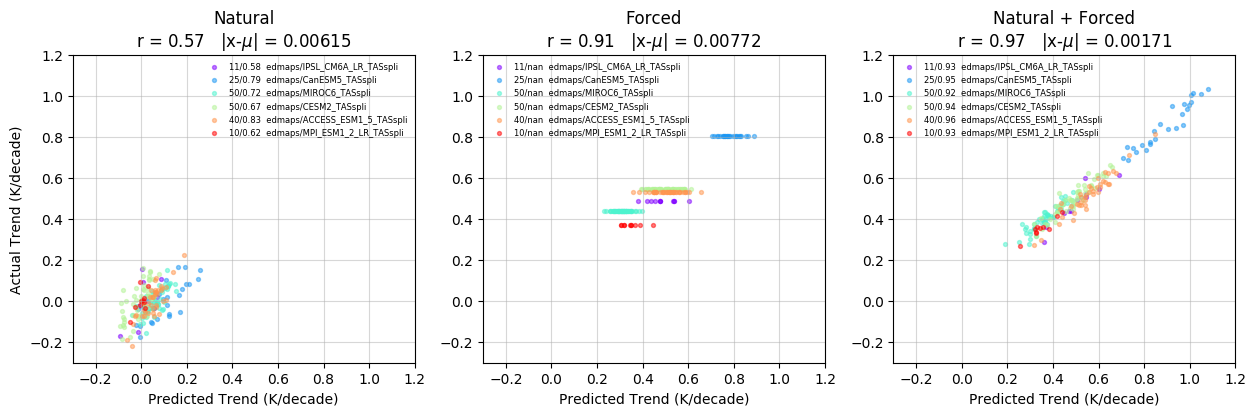

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
import matplotlib.cm as cm

####################################################################################
colors = cm.rainbow(np.linspace(0, 1, 6))
NatValAndPred = []
ForValAndPred = []
TotValAndPred = []
for model_idx in range(len(NameValidatationPredictions)):
    modelName = NameValidatationPredictions[model_idx][0]    
    ValidationData = NameValidatationPredictions[model_idx][1]
    PredictedData = NameValidatationPredictions[model_idx][2]
    TotalData = TestingTotalTrend[model_idx]
    N_ensembles = len(PredictedData)
    r_values = []
    for predictant_idx in range(3):
        axs_obj = axs[predictant_idx]

        # Natural Trend
        if predictant_idx == 0:
            val = ValidationData[:,2]
            pred = PredictedData[:,0]
            NatValAndPred.append([val, pred])
            axs_obj.set_ylabel('Actual Trend (K/decade)')

        # Forced Trend
        elif predictant_idx == 1:
            val = ValidationData[:,5]
            pred = PredictedData[:,1]
            ForValAndPred.append([val, pred])
        
        # Total Trend
        elif predictant_idx == 2:
            val = TotalData
            pred = PredictedData[:,0] + PredictedData[:,1]
            TotValAndPred.append([val, pred])

        #Plotting
        r = stats.pearsonr(val, pred)[0]
        label_id = str(N_ensembles) + '/' + str(r)[:4] + ' ' + ' ' + modelName
        
        axs_obj.scatter(pred, val, label=label_id, color=colors[model_idx], s=8, alpha=0.5)
        axs_obj.legend(loc=0, prop={'size': 6}, frameon=False)
        axs_obj.set_ylim(-0.3, 1.2)
        axs_obj.set_xlim(-0.3, 1.2)
        axs_obj.set_xlabel('Predicted Trend (K/decade)')
        axs_obj.grid(alpha=0.5)

# Give scores across all models and ensemble members
NatValAndPred = np.array(NatValAndPred)
ForValAndPred = np.array(ForValAndPred)
TotValAndPred = np.array(TotValAndPred)
AllModelAllEnsemble = [NatValAndPred, ForValAndPred, TotValAndPred]
titles = ['Natural', 'Forced', 'Natural + Forced']
for i in range(3):
    axs_obj = axs[i]
    val_pred_data = AllModelAllEnsemble[i]
    vals = list(np.concatenate(val_pred_data[:,0]).flat)
    preds = list(np.concatenate(val_pred_data[:,1]).flat)
    allsimulation_r = stats.pearsonr(vals, preds)[0]
    avg_deviation = np.nanmean(np.square((np.array(vals) - np.array(preds))))
    axs_obj.set_title(titles[i] + '\nr = ' + str(allsimulation_r)[:4] + '   |x-$\mu$| = ' + str(avg_deviation)[:7])